In [46]:
import torch
from torch import Tensor, nn
# from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
# from torch.utils.data.dataset import IterableDataset
import torchvision

from pytorch_lightning import LightningModule, Trainer
# import segmentation_models_pytorch as smp

import kornia as K
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# from PIL import Image

import cv2
# import re
# import ctypes
# import multiprocessing as mp

import random
import os

%matplotlib inline

In [33]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH_IMAGE =  'data/transformed_image/'
PATH_MASK =  'data/transformed_mask_1/'

list_train = os.listdir(PATH_MASK + 'train')
list_val = os.listdir(PATH_MASK + 'val')

In [34]:
list_train = ['train/' + string for string in list_train]
list_val = ['val/' + string for string in list_val]

In [35]:
list_train[5]

'train/12000_12000.png'

In [36]:
img = torchvision.io.read_image(PATH_IMAGE + f'{list_train[5]}')
target = torchvision.io.read_image(PATH_MASK + f'{list_train[5]}')
# img = img.unsqueeze(0).float()
# target = target.unsqueeze(0).float()
img.shape, target.shape 

(torch.Size([3, 1500, 1500]), torch.Size([1, 1500, 1500]))

In [39]:
new_PATH_MASK = '../AerialImageDataset/train/images'
new_PATH_IMAGE = '../AerialImageDataset/train/gt'


In [42]:
new_list_train = os.listdir(new_PATH_MASK)
new_list_train[0]

'chicago13.tif'

In [45]:
new_PATH_IMAGE + f'/{new_list_train[5]}', new_PATH_MASK + f'/{new_list_train[5]}'

('../AerialImageDataset/train/gt/austin23.tif',
 '../AerialImageDataset/train/images/austin23.tif')

In [49]:
img = cv2.imread(new_PATH_IMAGE + f'/{new_list_train[5]}')
target = cv2.imread(new_PATH_MASK + f'/{new_list_train[5]}', )
# img = img.unsqueeze(0).float()
# target = target.unsqueeze(0).float()
img.shape, target.shape 

((5000, 5000, 3), (5000, 5000, 3))

In [30]:
# define some augmentations
class Preprocessing(nn.Module):
    # to dataloader
    _preprocess =  K.augmentation.AugmentationSequential(
    K.augmentation.RandomCrop((320, 320)),
    data_keys=['input', 'mask'],
    )

    def __init__(self):
        super(Preprocessing, self).__init__()
        
    @torch.no_grad()
    def forward(self, img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x, y = self.preprocess(img, mask)
        return x[0], y[0]

    def preprocess(self, img: torch.Tensor, mask: torch.Tensor) -> dict:
        return self._preprocess(img, mask)


class Augmentation(nn.Module):
    # to SegModel
    _augmentations = K.augmentation.AugmentationSequential(
    K.augmentation.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    K.augmentation.RandomHorizontalFlip(p=0.5),
    K.augmentation.RandomVerticalFlip(p=0.5),
    K.augmentation.RandomRotation(20, p=0.8),
    K.augmentation.ColorJitter(0.15, 0.25, 0.25, 0.25, p=0.5),
    K.augmentation.RandomAffine([-45., 45.], [0., 0.15], [0.5, 1.5], [0., 0.15], p=0.6),
    data_keys=['input', 'mask'],
    same_on_batch=False,
    )

    def __init__(self):
        super(Augmentation, self).__init__()

    @torch.no_grad()
    def forward(self, img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        return self.augmentations(img, mask)

    def augmentations(self, img: torch.Tensor, mask: torch.Tensor) -> dict:
        x, y = self._augmentations(img, mask)
        return x, y


In [7]:
Pre = Preprocessing()
img_pre, target_pre = Pre(img/255., target/255.)

In [8]:
img.shape, img_pre.shape, target.shape, target_pre.shape

(torch.Size([3, 1500, 1500]),
 torch.Size([3, 320, 320]),
 torch.Size([1, 1500, 1500]),
 torch.Size([1, 320, 320]))

In [9]:
Aug = Augmentation()
new_dict = Aug.augmentations(img_pre, target_pre)

In [10]:
len(new_dict)

2

In [11]:
new_dict[1].shape

torch.Size([1, 1, 320, 320])

In [12]:
class GeoDataset(Dataset):

    def __init__(self,
     list_names, preprocess, c, h, w):
        self.shared_image = torch.zeros(c, h, w).share_memory_()
        self.shared_mask = torch.zeros(1, h, w).share_memory_()
        self.preprocess = preprocess
        self.list_names = list_names

    @torch.no_grad()
    def get_img(self, idx):
        if type(self.list_names) ==  list:
            # name = random.choice(self.list_names)
            # name = next(iter(self.list_names))
            name = self.list_names[idx]
        self.shared_image = torchvision.io.read_image(PATH_IMAGE + f'{name}') / 255.
        self.shared_mask =  torchvision.io.read_image(PATH_MASK + f'{name}') / 255.

    def __len__(self):
        return len(self.list_names)
    
    def __getitem__(self, idx):
        # if idx%1 == 0:
        self.get_img(idx)
        return self.preprocess(self.shared_image, self.shared_mask)

In [20]:
train_dataset = GeoDataset(
    # image=image_train, mask=mask_train, 
    preprocess=Pre,
    list_names=list_train,
    c=3, h=1500, w=1500)
train_dataloader = DataLoader(train_dataset, batch_size=2, num_workers=2, shuffle=True)
val_dataset = GeoDataset(
    # image=image_train, mask=mask_train, 
    preprocess=Pre,
    list_names=list_val,
    c=3, h=1500, w=1500)
val_dataloader = DataLoader(val_dataset, batch_size=2, num_workers=2)

In [21]:
i, m = next(iter(train_dataloader))
# for i, m in val_dataloader:
#     print(i.shape, m.shape)
#     break


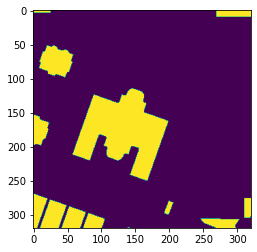

In [22]:
plt.imshow(m[0].permute(1,2,0).cpu().detach().numpy())

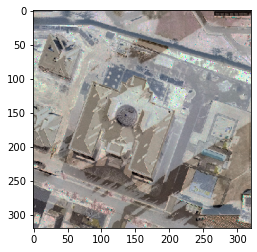

In [23]:
# plt.imshow(i[0].permute(1,2,0))
plt.imshow(i[0].permute(1,2,0).cpu().detach().numpy())

In [24]:
# cross = nn.CrossEntropyLoss() 
# smp.losses.DiceLoss(mode='multiclass', )
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc


loss = DiceLoss()

In [25]:
import segmentation_models_pytorch as smp

In [26]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    # encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [27]:
loss = smp.losses.DiceLoss(mode='binary')

In [28]:
class SemSegment(LightningModule):
    def __init__(
        self,
        lr: float = 0.0001,
        num_classes: int = 1,
        bilinear: bool = False,
        augmentation = Aug,
    ):
        super().__init__()

        self.bilinear = bilinear
        self.lr = lr
        # self.net = smp.Unet(encoder_name='resnet18', classes=num_classes)
    #     self.net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    # in_channels=3, out_channels=num_classes, init_features=32, pretrained=False)
        self.net = model
        self.loss = loss
        self.augmentation = augmentation

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        img, mask = self.augmentation(img, mask)
        out = self(img)
        # print(f'img size {img.shape}  out size {out.shape}  mask size {mask.shape}')
        loss_train_dice = self.loss(out, mask)
        # Логи тренировочных шагов для tensorboard
        self.log('train_dice_step', loss_train_dice, on_step=True, )

        return {"loss": loss_train_dice, "log": loss_train_dice.detach(), "progress_bar": loss_train_dice.detach()}

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img, mask = self.augmentation(img, mask)
        out = self(img)
        # print(f'img size {img.shape}  out size {out.shape}  mask size {mask.shape}')
        loss_val_dice = self.loss(out, mask)
        # Логи валидационных шагов для tensorboard
        self.log('val_dice_step', loss_val_dice, on_step=True)

        return {"val_loss": loss_val_dice}


    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x["val_loss"] for x in outputs]).mean()
        log_dict = {"val_loss": loss_val.detach()}
        # Логи валидационных эпох для tensorboard
        self.log('val_epoch_total_step', log_dict['val_loss'], on_epoch=True)

        return log_dict

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'),
            'monitor' : 'train_dice_step',
        }
        return {
                "optimizer": optimizer,
                "lr_scheduler": scheduler,
                }


In [29]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [30]:
# model = SemSegment.load_from_checkpoint('lightning_logs/best/epoch=222-step=16501.ckpt')
model = SemSegment()
checkpoint_callback = ModelCheckpoint(dirpath="lightning_logs/best", save_top_k=1, monitor="val_epoch_total_step")


In [31]:
trainer = Trainer(gpus=1,
 max_epochs=5000,
 callbacks=[checkpoint_callback]
 )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [32]:
trainer.fit(model,
 train_dataloader, val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type         | Params
----------------------------------------------
0 | net          | Unet         | 67.1 M
1 | loss         | DiceLoss     | 0     
2 | augmentation | Augmentation | 0     
----------------------------------------------
67.1 M    Trainable params
0         Non-trainable params
67.1 M    Total params
268.381   Total estimated model params size (MB)
/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/tims/work/myprojects/geo/image_processing/lightning_logs/best exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tims/miniconda3/envs/geo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
model = SemSegment.load_from_checkpoint('lightning_logs/best/epoch=871-step=64527.ckpt')

In [ ]:
model.eval()
model.to('cuda:0')

In [ ]:
img, msk = next(iter(val_dataloader))
print(img.shape, msk.shape)

In [ ]:
out = model(img.to('cuda'))
msk = msk.to('cuda')

In [ ]:
out[0].shape

In [ ]:
plt.imshow(img[0].permute(1,2,0).cpu().detach().numpy())

In [ ]:
plt.imshow(msk[0].permute(1,2,0).cpu().detach().numpy())

In [ ]:
plt.imshow(out[0].permute(1,2,0).cpu().detach().numpy())

In [ ]:
# dice(out, msk.type(torch.long).permute(0, 3, 1, 2))
# dice(out[0], msk[0].type(torch.float).permute(2, 0, 1))